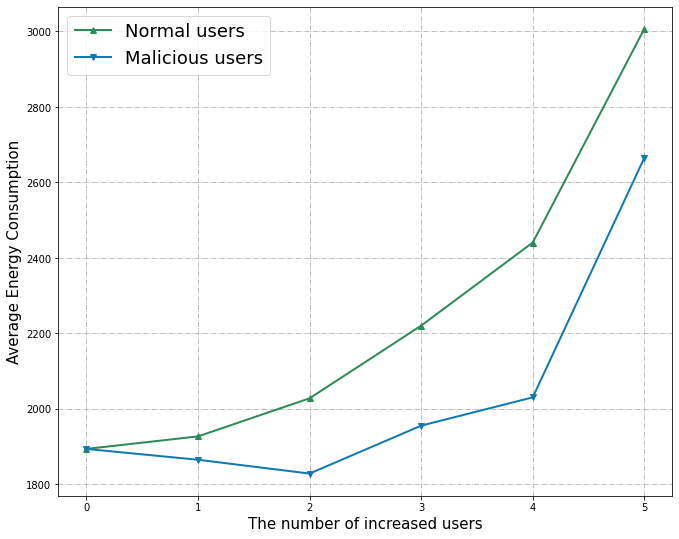

In [ ]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import math

# 准备各个用户数据
from tensorflow.examples.tutorials.mnist import input_data 
mnist=input_data.read_data_sets('MNIST data',one_hot=True)
datas=mnist.train.images
labels=mnist.train.labels

bs_number=4
good_user_number=10


all_user_data=[]
all_user_label=[]

for i in range(good_user_number):
  all_user_data.append(datas[i*4000:(i+1)*4000,])
  all_user_label.append(labels[i*4000:(i+1)*4000,])

test_data=mnist.test.images[:100]
test_label=mnist.test.labels[:100]


channel_number = 20

channel_state = [[0.6,0.3,0.1], [0.3,0.1,0.6], [0.1,0.6,0.3]]  # Transition probability of computation capbility: bad, Medium, Good
snr = np.array([1, 7, 15])
bandwidth = 20 * 10**6  # 2MHz

computation_state = [[0.7,0.2,0.1],[0.2,0.1,0.7],[0.1,0.7,0.2]]
# computation_state = [[0.5,0.3,0.2],[0.3,0.5,0.2],[0.2,0.3,0.5]]
bs_comp_capacity = np.array([20, 60, 100]) #GHz
user_comp_capacity = np.array([1, 3, 5])  #GHz


alpha = 0.01 #G cycles to generate or verify a signature
beta = 0.0001 #G cycles to generate or verify a MAC
time_to_fl_limit=10000
time_to_bc_limit=10000
epsilon=10**(-28)
omega=10**6*8 #1Mb
theta_1=0.01 #G cycles
theta_2=0.0001  #G cycles
theta_3=0.005  #G cycles
power_b=16 #W 42dbm
power_u=0.5 #W 27dbm
user_data_size=4000 #sample


block_size_space = np.array([1 * (10**6), 2 * (10**6), 5 * (10**6), 11* (10**6)]) # blcok size 取 {1,2,5.5,11}M, 此处单位是Byte
block_producer_space = np.array([1,2,3,4]) #产生区块的节点
faulty_nodes = math.ceil((bs_number - 1)/3) #向上取整

# action格式:给用户和基站分配信道数，第一个数表示多余的信道分给谁，取值范围小于用户数加基站数（基站+用户），最后两个优化block size和产生区块的主节点
extra_channel = 1 
action = np.array([1] + [1] + [1])  


def reset(user_number):

  channel_space = np.arange(1, user_number + bs_number + 1)


  # state格式:用户与基站间SNR，基站与基站之间的SNR，基站和用户的计算能力,当前的委员会节点
  state = np.array([1] * user_number * bs_number + [1] * bs_number * user_number+ [1] * bs_number * bs_number + [1] * (bs_number + user_number) + [1] * user_number)
  n_features = len(state)

  action_space_size = len(block_size_space)*len(block_producer_space)*(len(channel_space)**(extra_channel))

  actionRangeMatrix = [channel_space for i in range(extra_channel)]
  actionRangeMatrix.append(block_size_space)  # 倒数第二维的取值范围
  actionRangeMatrix.append(block_producer_space)  # 倒数第一维的取值范围

  reseted_state=[]
  for i in range(2*user_number*bs_number+bs_number*bs_number):
    reseted_state.append(snr[i%3])
  reseted_state+=[20,60,100,100]
  for i in range(user_number):
    reseted_state.append(user_comp_capacity[i%3])
  reseted_state+=[1 for i in range(user_number)]

  n_actions = len(block_size_space)*len(block_producer_space)*len(channel_space)**(extra_channel)

  return n_features,n_actions,np.array(reseted_state),actionRangeMatrix


      


def theNiubiFunction(index):
    theResultIndexOfAixs = [0] * (extra_channel + 2)
    currentAixs = len(actionRangeMatrix) - 1
    while index > 0:
        currentAixsLength = len(actionRangeMatrix[currentAixs])
        theResultIndexOfAixs[currentAixs] = index % currentAixsLength
        index = int(index / currentAixsLength)
        currentAixs = currentAixs - 1

    return [actionRangeMatrix[x][theResultIndexOfAixs[x]] for x in range(extra_channel + 2)] 


# module = 0 表示对三者都优化; module = 1，表示信道分配固定；module = 2，表示block_size固定；module = 3，表示block_producer固定。
def move(state,action,module=0):  
    state_copy=state.copy()
    user_bs_snr_status = state_copy[:user_number * bs_number]
    user_bs_snr_status = np.reshape(user_bs_snr_status, (user_number, bs_number))  #user_number行，bs_number列
  
    bs_user_snr_status = state_copy[user_number * bs_number:user_number*bs_number+bs_number*user_number]
    bs_user_snr_status = np.reshape(bs_user_snr_status, (bs_number ,user_number))
    
    bs_snr_status = state_copy[user_number * bs_number+bs_number*user_number:user_number * bs_number +bs_number*user_number+ bs_number * bs_number]
    bs_snr_status = np.reshape(bs_snr_status, (bs_number, bs_number))
    
    bs_comp_status = state_copy[user_number * bs_number +bs_number*user_number+ bs_number * bs_number:user_number * bs_number +bs_number*user_number+ bs_number * bs_number + bs_number]

    user_comp_status = state_copy[user_number * bs_number +bs_number*user_number+ bs_number * bs_number + bs_number:user_number * bs_number +bs_number*user_number+ bs_number * bs_number + bs_number + user_number]

    user_committee_status = state_copy[user_number * bs_number +bs_number*user_number+ bs_number * bs_number + bs_number + user_number:]

    # print("--------------------------------state----------------------------")
    # print("-------------------user_bs_snr_status------------------")
    # print(user_bs_snr_status)
    # print("-----------------------bs_user_snr_status--------------")
    # print(bs_user_snr_status)
    # print("---------------bs_snr_status-------------------")
    # print(bs_snr_status)
    # print("---------------bs_comp_status----------------")
    # print(bs_comp_status)
    # print("-----------------user_comp_status---------------")
    # print(user_comp_status)
    # print("-----------------user_compmittee----------------")
    # print(user_committee_status)
    # print("---------------------user_good_status-------------")
    # print(user_isGood)

    
    #number of committee workers
    K=0
    for i in user_committee_status:
      if i == 1:
        K = K + 1
    



    # print("----------------K------------------")
    # print(K)



    #由于action不会改变状态，不需要根绝action对status修正。只需要根据state和action计算reward和限制条件。
    action_number = np.size(action)
    if module == 1:
        action[:extra_channel] = np.array([1]*(extra_channel))
    elif module == 2:
        action[extra_channel] = 11*(10**6) # 固定6M的block_size
    elif module == 3:
        action[-1] = 3 #固定block_producer为1号

    allocated_channel =np.array([1]*(user_number + bs_number)) #前user_number个数代表给用户分配的信道数，后bs_number个数代表给基站分配的信道数
    for i in range(action_number - 2):
        index = action[i] 
        allocated_channel[index-1]+=extra_channel*(channel_number-bs_number-user_number)

    user_allocated_channel = allocated_channel[:user_number]
    bs_allocated_channel = allocated_channel[user_number:user_number + bs_number]

    #blocksize
    block_size=action[-2]
    
    #producer的序号
    producer=action[-1]

    # print("--------------------------action--------------------------")
    # print("------------user_allocated_channel------------")
    # print(user_allocated_channel)
    # print("------------bs_allocated_channel------------")
    # print(bs_allocated_channel)
    # print("---------------blocksize---------------")
    # print(block_size)
    # print("---------producer-----------")
    # print(producer)


 #FL的能耗与时延

  #(1) Local model融合得到global model及global model的广播
    producer_fuse_cpu_cycles=theta_3*K
    # print("---------producer_fuse_cpu_cycles-----------")
    # print(producer_fuse_cpu_cycles)
    producer_fuse_delay=producer_fuse_cpu_cycles/bs_comp_status[producer-1]
    # print("-------------producer_fuse_delay---------------")
    # print(producer_fuse_delay)
    primary_user_snr=bs_user_snr_status[producer-1,:]
    primary_user_rate=bs_allocated_channel[producer-1]*bandwidth*np.log2(1+primary_user_snr) 
    # print("-------------primary_user_rate---------------")
    # print(primary_user_rate)

    primary_user_delay=omega/primary_user_rate
    primary_user_ec=primary_user_delay*power_b
    # print("-------------primary_user_ec---------------")
    # print(primary_user_ec)


  #(2) Workers当地训练及上传
    #committee workers验证global model的CPU消耗和时间消耗
    committeer_validate_global_model_cpu_cycles=user_isGood*user_committee_status*theta_2*user_data_size
    # print("-------------committeer_validate_global_model_cpu_cycles---------------")
    # print(committeer_validate_global_model_cpu_cycles)
    committeer_validate_global_model_delay=committeer_validate_global_model_cpu_cycles/user_comp_status
    # print("-------------committeer_validate_global_model_delay---------------")
    # print(committeer_validate_global_model_delay)

    
    #committee workers上传global model的score(忽略)

    #workers进行local training的CPU消耗与时间消耗
    user_train_cpu_cycles=user_isGood*user_committee_status*theta_1*user_data_size
    # print("-------------user_train_cpu_cycles---------------")
    # print(user_train_cpu_cycles)
    user_train_delay=user_train_cpu_cycles/user_comp_status
    # print("-------------user_train_delay---------------")
    # print(user_train_delay)
    
    #workers上传global model
    user_primary_snr=user_bs_snr_status[:,producer-1]
    user_primary_rate=user_allocated_channel*bandwidth*np.log2(1+user_primary_snr)
    # print("-------------user_primary_rate---------------")
    # print(user_primary_rate)
    user_primary_delay=omega/user_primary_rate
    user_primary_ec=user_primary_delay*power_u
    # print("-------------user_primary_ec---------------")
    # print(user_primary_ec)
    
  #(3) Committee workers的验证及score的上传
    #将M个local model传播给committee workers时延以及能耗
    primary_committee_delay=user_committee_status*user_number*omega/primary_user_rate
    # print("-------------primary_committee_delay---------------")
    # print(primary_committee_delay)
    primary_committee_ec=primary_committee_delay*power_b
    # print("-------------primary_committee_ec---------------")
    # print(primary_committee_ec)
    #committee workers的验证
    committeer_validate_local_model_cpu_cycles=user_isGood*user_committee_status*user_number*theta_2*user_data_size
    # print("-------------committeer_validate_local_model_cpu_cycles---------------")
    # print(committeer_validate_local_model_cpu_cycles)
    committeer_validate_local_model_delay=committeer_validate_local_model_cpu_cycles/user_comp_status
    # print("-------------committeer_validate_local_model_delay---------------")
    # print(committeer_validate_local_model_delay)
    #score的上传（忽略）
  #(4) score的统计（忽略）

  #计算FL的总能耗与时间消耗
    
    #能耗
    #producer的计算能耗
    Bp_ec=(10**27)*epsilon*(bs_comp_status[producer-1]**2)*producer_fuse_cpu_cycles
    # print("-------------Bp_ec---------------")
    # print(Bp_ec)

    #传输总能耗
    trans_FL_ec=np.sum(primary_user_ec)+np.sum(user_primary_ec)+np.sum(primary_committee_ec)
    # print("-------------trans_FL_ec---------------")
    # print(trans_FL_ec)

    #user的计算总能耗
    train_and_validate_ec=(10**27)*epsilon*(np.sum((user_comp_status**2)*committeer_validate_global_model_cpu_cycles)\
                    +np.sum((user_comp_status**2)*user_train_cpu_cycles)\
                    +np.sum((user_comp_status**2)*committeer_validate_local_model_cpu_cycles))
    # print("-------------train_and_validate_ec---------------")
    # print(train_and_validate_ec)

    
    total_FL_ec=Bp_ec+trans_FL_ec+train_and_validate_ec

    # print("-------------total_FL_ec---------------")
    # print(total_FL_ec)

    #时间消耗
    total_FL_delay=producer_fuse_delay\
           +np.max(primary_user_delay+\
            (committeer_validate_global_model_delay+user_train_delay)+user_primary_delay)\
           +np.max(primary_committee_delay+committeer_validate_local_model_delay)

    # print("-------------total_FL_delay---------------")
    # print(total_FL_delay)

 #BC的能耗与时延
  #传输时延
    bs_rate = bandwidth * np.transpose([bs_allocated_channel]) * np.log2(1 + bs_snr_status) # 对应基站到基站的传输速率
    for i in range(len(bs_rate)):
      bs_rate[i,i]=-1
    # print(bs_rate)
  #(2) pre_prepare
    primary_bs_rate = bs_rate[producer - 1, :]
    pre_p_trans_delay =  block_size*8/primary_bs_rate
    pre_p_trans_delay = np.where(pre_p_trans_delay>0,pre_p_trans_delay,0)
    # print("-------------pre_p_trans_delay---------------")
    # print(pre_p_trans_delay)

  #(3) prepare
    pre_bs_rate = np.delete(bs_rate, producer - 1, axis=0)
    pre_trans_delay = block_size*8/pre_bs_rate
    pre_trans_delay = np.where(pre_trans_delay>0,pre_trans_delay,0)
    # print("-------------pre_trans_delay---------------")
    # print(pre_trans_delay)

  #(4) commit    
    com_trans_delay = block_size*8/bs_rate
    com_trans_delay = np.where(com_trans_delay>0,com_trans_delay,0)
    # print("-------------com_trans_delay---------------")
    # print(com_trans_delay)
  #(5) reply
    rep_bs_primary_rate = bs_rate[:,producer-1]
    rep_trans_delay = block_size*8/rep_bs_primary_rate
    rep_trans_delay = np.where(rep_trans_delay>0,rep_trans_delay,0)
    # print("-------------rep_trans_delay--------------")
    # print(rep_trans_delay)

  #计算时间
  #(1) 验证M+1个交易的签名和MAC   
    bs_validate_transition_cpu_cycles=np.array([0.] * bs_number)
    bs_validate_transition_cpu_cycles[producer-1]=(block_size*8/omega)*(alpha+beta)
    bs_validate_transition_delay=np.max(bs_validate_transition_cpu_cycles/bs_comp_status)
    # print("-------------bs_validate_transition_delay---------------")
    # print(bs_validate_transition_cpu_cycles/bs_comp_status)
  
  #(2) pre_prepare
    bs_pre_p_cpu_cycles=np.array([1.] * bs_number)
    bs_pre_p_cpu_cycles=bs_pre_p_cpu_cycles*(alpha+beta+(block_size*8/omega)*(alpha+beta))
    bs_pre_p_cpu_cycles[producer-1]=alpha+(bs_number-1)*beta
    bs_pre_p_comp_delay=np.max(bs_pre_p_cpu_cycles/bs_comp_status)
    # print("-------------bs_pre_p_comp_delay---------------")
    # print(bs_pre_p_cpu_cycles/bs_comp_status)
  #(3) prepare
    bs_pre_cpu_cycles=np.array([1.] * bs_number)
    bs_pre_cpu_cycles=bs_pre_cpu_cycles*(alpha+(bs_number-1)*beta+2*faulty_nodes*(alpha+beta))
    bs_pre_cpu_cycles[producer-1]=2*faulty_nodes*(alpha+beta)
    bs_pre_comp_delay=np.max(bs_pre_cpu_cycles/bs_comp_status)
    # print("-------------bs_pre_comp_delay---------------")
    # print(bs_pre_cpu_cycles/bs_comp_status)

  #(4) commit
    bs_commit_cpu_cycles=np.array([1.] * bs_number)
    bs_commit_cpu_cycles=bs_commit_cpu_cycles*(alpha+(bs_number-1)*beta+2*faulty_nodes*(alpha+beta))
    bs_commit_comp_delay=np.max(bs_commit_cpu_cycles/bs_comp_status)
    # print("-------------bs_commit_comp_delay---------------")
    # print(bs_commit_cpu_cycles/bs_comp_status)
   
  #(5) reply
    bs_reply_cpu_cycles=np.array([1.] * bs_number)
    # bs_reply_cpu_cycles=bs_reply_cpu_cycles*((block_size*8/omega)*(alpha+beta))
    bs_reply_cpu_cycles=bs_reply_cpu_cycles*(alpha+beta)
    bs_reply_cpu_cycles[producer-1]=2*faulty_nodes*(alpha+beta)
    # print(bs_reply_cpu_cycles)
    bs_reply_comp_delay=np.max(bs_reply_cpu_cycles/bs_comp_status)
    # print("-------------bs_reply_comp_delay--------------")
    # print(bs_reply_cpu_cycles/bs_comp_status)
  
  
  #时间消耗：
    total_BC_delay=np.max(pre_p_trans_delay)+np.max(pre_trans_delay)+np.max(com_trans_delay)\
    +np.max(rep_trans_delay)\
    +bs_validate_transition_delay+bs_pre_p_comp_delay+bs_pre_comp_delay+bs_commit_comp_delay\
    +bs_reply_comp_delay
    # print("-------------total_BC_delay---------------")
    # print(total_BC_delay)

  #能耗
  #传输能耗
    trans_BC_ec=np.ceil((user_number+1)*omega/(block_size*8))*np.sum(pre_p_trans_delay)*power_b+np.sum(pre_trans_delay)*power_b\
    +np.sum(com_trans_delay)*power_b+np.sum(rep_trans_delay)*power_b
    # print("-------------trans_BC_ec---------------")
    # print(trans_BC_ec)

  #计算能耗
    total_cpu_cycles=(bs_validate_transition_cpu_cycles+bs_pre_p_cpu_cycles+bs_pre_cpu_cycles\
    +bs_commit_cpu_cycles+bs_reply_cpu_cycles)
    # print("-------------total_cpu_cycles---------------")
    # print(total_cpu_cycles)
    comp_BC_ec=np.ceil((user_number+1)*omega/(block_size*8))*np.sum((10**27)*epsilon*(bs_comp_status**2)*(total_cpu_cycles))
    # print("-------------comp_BC_ec---------------")
    # print(comp_BC_ec)
    
  #BC总能耗
    total_BC_ec=trans_BC_ec+comp_BC_ec
    # print("-------------total_BC_ec---------------")
    # print(total_BC_ec)
 #总能耗
    total_ec=total_FL_ec+total_BC_ec
    
    
 #reward
    if total_FL_delay>time_to_fl_limit or total_BC_delay>time_to_bc_limit:
      reward=0
    else:
      reward=10000/total_ec
      #reward=2000*(1/(trans_FL_ec+trans_BC_ec)+74/comp_BC_ec)
      # reward=2000*(1/(trans_FL_ec+trans_BC_ec)+400/comp_BC_ec)
      # j1.append(trans_FL_ec+trans_BC_ec)
      # j2.append(comp_BC_ec)
    # print("trans_FL_ec+trans_BC_ec: "+str(trans_FL_ec+trans_BC_ec))
    # print("comp_BC_ec: "+str(comp_BC_ec))
    # print("total_ec: "+str(total_ec))
      
#状态转移
    for i in range(user_number):
        for j in range(bs_number):
            temp = random.uniform(0,1)
            if user_bs_snr_status[i, j] == 1:
                if temp < 0.1:
                    user_bs_snr_status[i, j] = 15
                elif temp<0.4:
                    user_bs_snr_status[i, j] = 7
            if user_bs_snr_status[i, j] == 7:
                if temp < 0.6:
                    user_bs_snr_status[i, j] = 15
                elif temp < 0.9:
                    user_bs_snr_status[i, j] = 1
            if user_bs_snr_status[i, j] == 15:
                if temp < 0.1:
                    user_bs_snr_status[i, j] = 1
                elif temp < 0.7:
                    user_bs_snr_status[i, j] = 7
                    
    for i in range(bs_number):
        for j in range(user_number):
            temp = random.uniform(0,1)
            if bs_user_snr_status[i, j] == 1:
                if temp < 0.1:
                    bs_user_snr_status[i, j] = 15
                elif temp<0.4:
                    bs_user_snr_status[i, j] = 7
            if bs_user_snr_status[i, j] == 7:
                if temp < 0.6:
                    bs_user_snr_status[i, j] = 15
                elif temp < 0.9:
                    bs_user_snr_status[i, j] = 1
            if bs_user_snr_status[i, j] == 15:
                if temp < 0.1:
                    bs_user_snr_status[i, j] = 1
                elif temp < 0.7:
                    bs_user_snr_status[i, j] = 7
    for i in range(bs_number):
        for j in range(bs_number):
            if i==j:
                bs_snr_status[i, j] = 1
            else:
                temp = random.uniform(0,1)
                if bs_snr_status[i, j] == 1:
                    if temp < 0.1:
                        bs_snr_status[i, j] = 15
                    elif temp<0.4:
                        bs_snr_status[i, j] = 7
                if bs_snr_status[i, j] == 7:
                    if temp < 0.6:
                        bs_snr_status[i, j] = 15
                    elif temp < 0.9:
                        bs_snr_status[i, j] = 1
                if bs_snr_status[i, j] == 15:
                    if temp < 0.1:
                        bs_snr_status[i, j] = 1
                    elif temp < 0.7:
                        bs_snr_status[i, j] = 7
                    
    for i in range(bs_number):
        bs_comp=bs_comp_status[i]
        temp = random.uniform(0,1)
        if bs_comp == bs_comp_capacity[0]:
          if temp < computation_state[0][1]:
              bs_comp_status[i] = bs_comp_capacity[1]
          elif temp < computation_state[0][1]+computation_state[0][2]:
              bs_comp_status[i] = bs_comp_capacity[2]
        if bs_comp == bs_comp_capacity[1]:
          if temp < computation_state[1][0]:
              bs_comp_status[i] = bs_comp_capacity[0]
          elif temp < computation_state[1][0]+computation_state[1][2]:
              bs_comp_status[i] = bs_comp_capacity[2]
        if bs_comp == bs_comp_capacity[2]:
          if temp < computation_state[2][0]:
              bs_comp_status[i] = bs_comp_capacity[0]
          elif temp < computation_state[2][0]+computation_state[2][1]:
              bs_comp_status[i] = bs_comp_capacity[1]
    for i in range(user_number):
        user_comp=user_comp_status[i]
        temp = random.uniform(0,1)
        if user_comp == user_comp_capacity[0]:
          if temp < 0.2:
              user_comp_status[i] = user_comp_capacity[1]
          elif temp < 0.3:
              user_comp_status[i] = user_comp_capacity[2]
        if bs_comp == user_comp_capacity[1]:
          if temp < 0.2:
              user_comp_status[i] = user_comp_capacity[0]
          elif temp < 0.9:
              user_comp_status[i] = user_comp_capacity[2]
        if bs_comp == user_comp_capacity[2]:
          if temp < 0.1:
              user_comp_status[i] = user_comp_capacity[0]
          elif temp < 0.8:
              user_comp_status[i] = user_comp_capacity[1]
                
    
    
    # 将新的shape整合成原先的shape
    user_bs_snr_status = np.reshape(user_bs_snr_status, user_number * bs_number)
    bs_user_snr_status = np.reshape(bs_user_snr_status, bs_number * user_number)
    bs_snr_status = np.reshape(bs_snr_status, bs_number * bs_number)
    
    # print("----------------------------------------state_-------------------------------")
    # print(user_bs_snr_status)
    # print(bs_user_snr_status)
    # print(bs_snr_status)
    # print(bs_comp_status)
    # print(user_comp_status)

    state_ = np.concatenate((user_bs_snr_status, bs_user_snr_status, bs_snr_status, bs_comp_status, user_comp_status))
    
    
    return state_, reward, total_ec
  
    

#联邦学习模型
class FL:
    def __init__(self,name,sess,data=None,label=None,isCommittee=False,isBad=False,lr=0.0005):
        self.lr=lr    #LEARNING_RATE
        self.sess=sess
        self.name=name
        self.c_name=self.name+"params"
        self.parameters=self.build_net(self.c_name)
        self.data=data
        self.label=label
        self.isCommittee=isCommittee
        self.isBad=isBad
        
        
        
    def build_net(self,c_name):
        CONV_SIZE = 3
        CONV_1_KERNAL = 32 
        CONV_2_KERNAL = 64
        
        W_INITIALIZER=tf.truncated_normal_initializer(0,0.05)
        B_INITIALIZER=tf.constant_initializer(0.03)

                    
        # 卷积神经网络
        def params(name,shape,initializer,c_names):
            return tf.get_variable(name,shape,initializer=initializer,collections=c_names)
        
        def conv2d(x,w):
            return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding="SAME")
        
        def pool(x):
            return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
        
        self.x=tf.placeholder(tf.float32,[None,784],name="input_features")
        self.y=tf.placeholder(tf.float32,[None,10],name="actual_labels")
        self.keep_prob=tf.placeholder(tf.float32,name="keep_prob")
        image_x=tf.reshape(self.x,[-1,28,28,1])
        
        c_names=[tf.GraphKeys.GLOBAL_VARIABLES,c_name]
        with tf.variable_scope("conv_1"):
            conv_1_w=params("conv_1_w",[CONV_SIZE,CONV_SIZE,1,CONV_1_KERNAL],W_INITIALIZER,c_names)
            conv_1_b=params("conv_1_b",CONV_1_KERNAL,B_INITIALIZER,c_names)
            conv_1_out=tf.nn.relu(conv2d(image_x,conv_1_w)+conv_1_b)
            l1=tf.nn.dropout(pool(conv_1_out),self.keep_prob)
        
        
        with tf.variable_scope("conv_2"):
            conv_2_w=params("conv_2_w",[CONV_SIZE,CONV_SIZE,CONV_1_KERNAL,CONV_2_KERNAL],W_INITIALIZER,c_names)
            conv_2_b=params("conv_2_b",CONV_2_KERNAL,B_INITIALIZER,c_names)
            conv_2_out=tf.nn.relu(conv2d(l1,conv_2_w)+conv_2_b)
            l2=tf.nn.dropout(pool(conv_2_out),self.keep_prob)
        
        with tf.variable_scope("fc_1"):
            flattened_input=tf.reshape(l2,[-1,7*7*CONV_2_KERNAL])
            fc_1_w=params("fc_1_w",[7*7*CONV_2_KERNAL,512],W_INITIALIZER,c_names)
            fc_1_b=params("fc_1_b",512,B_INITIALIZER,c_names)
            l4=tf.nn.dropout(tf.nn.relu(tf.matmul(flattened_input,fc_1_w)+fc_1_b),self.keep_prob)
            
        with tf.variable_scope("fc_2"):
            fc_2_w=params("fc_2_w",[512,10],W_INITIALIZER,c_names)
            fc_2_b=params("fc_2_b",10,B_INITIALIZER,c_names)
            output=tf.nn.softmax(tf.matmul(l4,fc_2_w)+fc_2_b)  
        
             
        
        with tf.variable_scope("loss"):
            self.loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y,logits=output))
            
        with tf.variable_scope("accuracy"):
            self.accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.y,axis=1),tf.argmax(output,axis=1)),tf.float32))
            
        with tf.variable_scope("train"):
            # self.train_op=tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)
            self.Optimizer=tf.train.RMSPropOptimizer(self.lr)
            self.train_op=self.Optimizer.minimize(self.loss)
        
        return tf.get_collection(c_name)

    def train(self):
        batch_size=100
        n_batch=int(self.data.shape[0]/batch_size) 
        for i in range(n_batch):
            self.sess.run(self.train_op,feed_dict={self.x:self.data[i*batch_size:(i+1)*batch_size],
                  self.y:self.label[i*batch_size:(i+1)*batch_size],
                  self.keep_prob:1.0})
          

    def validate(self,data,label):
        batch_size=100
        n_batch=int(data.shape[0]/batch_size)
        acc=0
        for i in range(n_batch):
          x=self.sess.run(self.accuracy,feed_dict={self.x:data[i*batch_size:(i+1)*batch_size],
                              self.y:label[i*batch_size:(i+1)*batch_size],
                              self.keep_prob:1.0})
          acc+=(x/n_batch)
        return acc


#DRL模型
class DDQN:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.001,
            reward_decay=0.9,  # 腐蚀率  
            e_greedy=0.9,  # 探索新事物的概率
            replace_target_iter=300,
            memory_size=3000,
            batch_size=32,
            e_greedy_increment=0.0001,
            dueling=False,
            sess=None,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max
        
        self.dueling = dueling      # decide to use dueling DQN or not

        self.learn_step_counter = 0
        self.memory = np.zeros((self.memory_size, n_features*2+2))
        self._build_net()
        t_params = tf.get_collection('target_net_params')
        e_params = tf.get_collection('eval_net_params')
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        if sess is None:
            self.sess = tf.Session()
            self.sess.run(tf.global_variables_initializer())
        else:
            self.sess = sess
        self.cost_his=[]


    def _build_net(self):
        def build_layers(s, c_names, n_l1, n_l2, n_l3, w1_initializer,w2_initializer, w3_initializer, w4_initializer, w5_initializer, b_initializer):
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w1_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(s, w1) + b1)
                
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, n_l2], initializer=w2_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, n_l2], initializer=b_initializer, collections=c_names)
                l2 = tf.nn.relu(tf.matmul(l1, w2) + b2)
                
            with tf.variable_scope('l3'):
                w3 = tf.get_variable('w3', [n_l2, n_l3], initializer=w3_initializer, collections=c_names)
                self.w3=w3
                b3 = tf.get_variable('b3', [1, n_l3], initializer=b_initializer, collections=c_names)
                l3 = tf.nn.relu(tf.matmul(l2, w3) + b3)                

            if self.dueling:
                # Dueling DQN
                with tf.variable_scope('Value'):
                    w4 = tf.get_variable('w4', [n_l3, 1], initializer=w4_initializer, collections=c_names)
                    b4 = tf.get_variable('b4', [1, 1], initializer=b_initializer, collections=c_names)
                    self.V = tf.matmul(l3, w4) + b4

                with tf.variable_scope('Advantage'):
                    w4 = tf.get_variable('w4', [n_l3, self.n_actions], initializer=w5_initializer, collections=c_names)
                    b4 = tf.get_variable('b4', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                    self.A = tf.matmul(l3, w4) + b4

                with tf.variable_scope('Q'):
                    out = self.V + (self.A - tf.reduce_mean(self.A, axis=1, keep_dims=True))     # Q = V(s) + A(s,a)
            else:
                with tf.variable_scope('Q'):
                    w4 = tf.get_variable('w4', [n_l3, self.n_actions], initializer=w5_initializer, collections=c_names)
                    b4 = tf.get_variable('b4', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                    out = tf.matmul(l3, w4) + b4

            return out


        # ------------------ build evaluate_net ------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss
        
        with tf.variable_scope('eval_net'):
            c_names, n_l1, n_l2, n_l3, w1_initializer, w2_initializer, w3_initializer,w4_initializer, w5_initializer,b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 256 ,256 ,128, \
                tf.random_normal_initializer(stddev=(2/(32 + 256))**0.5), tf.random_normal_initializer(stddev=(2/512)**0.5),\
                tf.random_normal_initializer(stddev=(2/384)**0.5), tf.random_normal_initializer(stddev=(2/129)**0.5),\
                tf.random_normal_initializer(stddev=(2/(128 + 112))**0.5), tf.constant_initializer(0.1)  # config of layers

            self.q_eval = build_layers(self.s, c_names, n_l1, n_l2, n_l3, w1_initializer, w2_initializer, w3_initializer,w4_initializer,w5_initializer, b_initializer)

        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):  
            self._train_op = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')   
        with tf.variable_scope('target_net'):
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            self.q_next = build_layers(self.s_, c_names, n_l1, n_l2, n_l3, w1_initializer, w2_initializer, w3_initializer, w4_initializer, w5_initializer, b_initializer)

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        transition = np.hstack((s, [a, r], s_))
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition
        self.memory_counter += 1

      
    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]
        actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
        action_index = np.argmax(actions_value)
        
        action_number = channel_number - bs_number - user_number + 2
        action = np.array([1] * action_number)
        random_number=np.random.uniform()
        if random_number < self.epsilon:
            action_index = action_index
        else:
            action_index = np.random.randint(0, n_actions)           
        action = theNiubiFunction(action_index)
        # print("---------------action_index--------------")
        # print(action_index)
        # print("--------------action---------------")
        # print(action)
        return action, action_index
  

    def learn(self):
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
            
        sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        q_next, q_eval4next = self.sess.run([self.q_next, self.q_eval], feed_dict={self.s_: batch_memory[:, -self.n_features:],
                                                                                  self.s:batch_memory[:, -self.n_features:]}) # next observation
        q_eval = self.sess.run(self.q_eval, {self.s: batch_memory[:, :self.n_features]})

        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]
        

        selected_q_next = np.max(q_next, axis=1)  # the natural DQN
            
        
        q_target[batch_index, eval_act_index] = reward + self.gamma * selected_q_next  

        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)

        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot_cost(self):
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.grid(True)
        plt.show()




def broadcast(all_user_FL,global_FL,global_sess):
  global_model_broadcast=[]
  for user_FL in all_user_FL:
    global_model_broadcast+=[tf.assign(e,t) for e,t in zip(user_FL.parameters,global_FL.parameters)]
  global_sess.run(global_model_broadcast)

def committee_validate(committee_FL,all_user_FL,global_sess):
  all_user_FL_scores=[]
  if committee_FL.isBad==False:
    for user_FL in all_user_FL:
      all_user_FL_scores.append(user_FL.validate(committee_FL.data,committee_FL.label))
  else:
    for user_FL in all_user_FL:
      if user_FL.isBad==True:
        all_user_FL_scores.append(1.0)
      else:
        all_user_FL_scores.append(0.0)
  return all_user_FL_scores


tao=0.05

def get_next_global_model_and_commmittee_users(all_user_FL,global_model,all_user_FL_scores,global_model_score,global_sess):
  all_user_number=len(all_user_FL)
  global_sess.run([tf.assign(t,0*e) for t,e in zip(global_model.parameters,global_model.parameters)])
  k=0
  for i in range(all_user_number):
    all_user_FL[i].isCommittee=False
    score=all_user_FL_scores[i]
    if(score>global_model_score):
      k=k+1
      all_user_FL[i].isCommittee=True
      global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
  if k!=0:
    global_sess.run([tf.assign(t,e/k) for t,e in zip(global_model.parameters,global_model.parameters)])
  else:
    for i in range(all_user_number):
      all_user_FL[i].isCommittee=False
      score=all_user_FL_scores[i]
      if(score>global_model_score*(1-tao)):
        k=k+1
        all_user_FL[i].isCommittee=True
        global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
    if k!=0:
      global_sess.run([tf.assign(t,e/k) for t,e in zip(global_model.parameters,global_model.parameters)])
    else:
      for i in range(all_user_number):
        all_user_FL[i].isCommittee=True
        global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
      global_sess.run([tf.assign(t,e/all_user_number) for t,e in zip(global_model.parameters,global_model.parameters)])
  isCommittee=[0 for i in range(all_user_number)]
  for i in range(all_user_number):
    if(all_user_FL[i].isCommittee==True):
      isCommittee[i]=1
  return isCommittee

def local_train(all_user_FL,global_sess):
  for user_FL in all_user_FL:
    if user_FL.isBad==False:
      user_FL.train()
    else:
      global_sess.run([tf.assign(t,0*e) for  t,e in zip(user_FL.parameters,user_FL.parameters)])


def get_global_model_score(all_user_FL,global_model,global_sess):
  global_model_score=[]
  for user_FL in all_user_FL:
    if user_FL.isCommittee==True:
      if user_FL.isBad==False:
        global_model_score.append(global_model.validate(user_FL.data,user_FL.label))
      else:
        global_model_score.append(0.999999)
  delta=np.std(global_model_score)
  mean=np.mean(global_model_score)
  for i in range(len(global_model_score)-1,-1,-1):
    x=global_model_score[i]
    if x<mean-delta or x>mean+delta:
      global_model_score.remove(x)
  # print("global_model_score: "+str(np.mean(global_model_score)))
  return np.mean(global_model_score)


def get_all_user_FL_scores(all_user_FL,global_sess):
  all_user_number=len(all_user_FL)
  committee_to_all_user_FL_scores=[]
  for user_FL in all_user_FL:
    if user_FL.isCommittee==True:
      committee_to_all_user_FL_scores.append(committee_validate(user_FL,all_user_FL,global_sess))
  all_user_FL_scores=[]
  mean=np.mean(committee_to_all_user_FL_scores,0)
  delta=np.std(committee_to_all_user_FL_scores,0)
  for i in range(all_user_number):
    scores=np.array(committee_to_all_user_FL_scores)[:,i]
    for j in range(len(scores)-1,-1,-1):
      x=scores[j]
      if x<mean[i]-delta[i] or x>mean[i]+delta[i]:
        scores=np.delete(scores,[j])
    all_user_FL_scores.append(np.mean(scores))
  # print("all_user_FL_scores: "+str(all_user_FL_scores))
  return all_user_FL_scores


def replace_two_model_parameters(e_model,t_model,global_sess):
  global_sess.run([tf.assign(e,t) for e,t in zip(e_model.parameters,t_model.parameters)])

def get_FL(increased_user_number,increased_user_status=True):
  tf.reset_default_graph()
  tf.set_random_seed(1)
  global_sess=tf.Session()
  with tf.variable_scope("global_model"):
    global_model=FL("global_model",global_sess)
  all_user_FL=[]
  for i in range(good_user_number):
    name="u"+str(i)
    with tf.variable_scope(name):
      data=all_user_data[i]
      label=all_user_label[i]
      all_user_FL.append(FL(name,global_sess,data,label,isCommittee=True))

  if(increased_user_status):
    for i in range(increased_user_number):
      name="u"+str(i+good_user_number)
      data=datas[(good_user_number+i)*4000:(good_user_number+i+1)*4000]
      label=labels[(good_user_number+i)*4000:(good_user_number+i+1)*4000]
      with tf.variable_scope(name):
        all_user_FL.append(FL(name,global_sess,data,label,isCommittee=True,isBad=False))
  else:
    for i in range(increased_user_number):
      name="bad_u"+str(i)
      with tf.variable_scope(name):
        all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True)) 

  global_sess.run(tf.global_variables_initializer())
  return [global_sess,all_user_FL,global_model]


def iterate(global_sess,all_user_FL,global_model):
  global_model_score=get_global_model_score(all_user_FL,global_model,global_sess)
  broadcast(all_user_FL,global_model,global_sess)
  local_train(all_user_FL,global_sess)
  all_user_FL_scores=get_all_user_FL_scores(all_user_FL,global_sess)
  user_committee_status=get_next_global_model_and_commmittee_users(all_user_FL,global_model,all_user_FL_scores,global_model_score,global_sess)
  return global_model.validate(test_data,test_label),user_committee_status

def reset_all_user_FL(FLs):
  for user_FL in FLs:
    user_FL.isCommittee=True
  
def plot(x,xlabel,ylabel):
  figsize = 11,9
  figure, ax = plt.subplots(figsize=figsize)
  plt.plot(np.arange(0,len(x)),x,c="#2E8B57",linewidth=1)
  plt.ylabel(ylabel,fontsize=15)
  plt.xlabel(xlabel,fontsize=15)
  plt.grid(linestyle='-.')     
  plt.show()

color=['#2E8B57','#107ab0','orange','#be6400']
def plot_comparaed_fugure(n,value,label,xlabel,ylabel,name):
    figsize = 11,9
    figure, ax = plt.subplots(figsize=figsize)
    for i in range(n):
        plt.plot(np.arange(0,len(value[i])),value[i],c=color[i],label=label[i],linewidth=1)
    plt.legend(loc="best",fontsize=18)
    plt.ylabel(ylabel,fontsize=15)
    plt.xlabel(xlabel,fontsize=15)
    plt.grid(linestyle='-.')     
    plt.show()
markers=["^","v",".","s"]
def plot_dot_figure(n,value,label,xlabel,ylabel):
    figsize = 11,9
    figure, ax = plt.subplots(figsize=figsize)
    for i in range(n):
        plt.plot(np.arange(0,len(value[i])),value[i],c=color[i],marker=markers[i],label=label[i],linewidth=2)
    plt.legend(loc="best",fontsize=18)
    plt.ylabel(ylabel,fontsize=15)
    plt.xlabel(xlabel,fontsize=15)
    plt.grid(linestyle='-.')     
    plt.show()

max_episode=800  
max_iteration_number=30

def run(RL,module,max_episode=800):
    global_sess=tf.Session()
    total_reward=[]
    train_step=0
    t_ec_list=[]
    for i in range(max_episode):
      random.seed(0)     
      state=reseted_state  
      _reward_of_everyFL_list=[]

      # with graph_drl.as_default():
      #   print(sess.run(RL.w3)[2])   
      for j in range(max_iteration_number):
        action,action_index=RL.choose_action(state)
        state_pre,reward,t_ec=move(state,action,module)
        user_committee_status=user_committee_status_list[j]
        state_=np.concatenate((state_pre,np.array(user_committee_status)))
        _reward_of_everyFL_list.append(reward)  
        t_ec_list.append(t_ec)

        RL.store_transition(state,action_index,reward,state_)

        # if i>770:
        #   print(action[-2])

        state=state_
        train_step+=1
        if train_step>=RL.memory_size:
          RL.learn()
        # print("train_step: "+str(train_step)+"   reward: "+str(reward))
      
      # plot(_reward_of_everyFL_list,"no_"+str(i)+"_fl","reward")
      total_reward.append(np.sum(_reward_of_everyFL_list))
      if (i+1)%400==0:
        plot(total_reward,"no_"+str(i)+"_rl","Total Reward")
        t_ec_array=np.reshape(t_ec_list,[-1,30])
        plot(np.mean(t_ec_array,1),"Episode","Average Energy Consumption")

    return total_reward,t_ec_array


average_ec_with_user_number_true=[]
for i in range(6):
  tf.reset_default_graph()
  increased_user_number=i
  increased_user_status=True

  user_committee_status_list=[]

  # FL_list=get_FL(increased_user_number,increased_user_status)
  # print("accuracy of pre_train: "+str(FL_list[2].validate(test_data,test_label))) 
  # for j in range(max_iteration_number):
  #     accuracy,user_committee_status=iterate(FL_list[0],FL_list[1],FL_list[2])
  #     user_committee_status_list.append(user_committee_status)
  #     print(accuracy)

  # tf.reset_default_graph()
  # FL_list[0].close()

  import pandas as pd
  # pd.DataFrame(user_committee_status_list).to_csv("/content/drive/MyDrive/EE_blockchain/ra/backup/user_committee_status_list_"+str(i)+"_true.csv")
  user_committee_status_list=pd.read_csv("/content/drive/MyDrive/EE_blockchain/ra/backup/user_committee_status_list_"+str(i)+"_true.csv",index_col=0).values
  
  print(user_committee_status_list)

  user_number=good_user_number+increased_user_number
  n_features,n_actions,state,actionRangeMatrix=reset(user_number)
  reseted_state=state.copy()

  user_isGood=np.array([1 for i in range(good_user_number)])
  if increased_user_status:
    user_isGood=np.concatenate((user_isGood,[1 for i in range(increased_user_number)]))
  else:
    user_isGood=np.concatenate((user_isGood,[0 for i in range(increased_user_number)]))


  graph_drl=tf.Graph()
  sess=tf.Session(graph=graph_drl)

  with graph_drl.as_default():
    with tf.variable_scope("DDQN"):
      RL_0=DDQN(n_actions,n_features,learning_rate=0.0001,reward_decay=0.8,e_greedy=0.95,replace_target_iter=400,
              memory_size=3000,batch_size=32,e_greedy_increment=0.0001,dueling=True,sess=sess
      )
    tf.set_random_seed(0)
    sess.run(tf.global_variables_initializer())

  np.random.seed(0)
  total_reward_increase_true,total_ec_array_increase_true=run(RL_0,0)  

  graph_drl.as_default()
  sess.close()

  average_ec_with_user_number_true.append(np.mean(total_ec_array_increase_true[500:,:]))


average_ec_with_user_number_false=[]
for i in range(1,6):
  tf.reset_default_graph()
  increased_user_number=i
  increased_user_status=False

  user_committee_status_list=[]
  # FL_list=get_FL(increased_user_number,increased_user_status)
  # print("accuracy of pre_train: "+str(FL_list[2].validate(test_data,test_label))) 
  # for j in range(max_iteration_number):
  #     accuracy,user_committee_status=iterate(FL_list[0],FL_list[1],FL_list[2])
  #     user_committee_status_list.append(user_committee_status)
  #     print(accuracy)

  # tf.reset_default_graph()
  # FL_list[0].close()

  import pandas as pd
  # pd.DataFrame(user_committee_status_list).to_csv("/content/drive/MyDrive/EE_blockchain/ra/backup/user_committee_status_list_"+str(i)+"_false.csv")
  user_committee_status_list=pd.read_csv("/content/drive/MyDrive/EE_blockchain/ra/backup/user_committee_status_list_"+str(i)+"_false.csv",index_col=0).values

  print(user_committee_status_list)

  user_number=good_user_number+increased_user_number
  n_features,n_actions,state,actionRangeMatrix=reset(user_number)
  reseted_state=state.copy()

  user_isGood=np.array([1 for i in range(good_user_number)])
  if increased_user_status:
    user_isGood=np.concatenate((user_isGood,[1 for i in range(increased_user_number)]))
  else:
    user_isGood=np.concatenate((user_isGood,[0 for i in range(increased_user_number)]))


  graph_drl=tf.Graph()
  sess=tf.Session(graph=graph_drl)

  with graph_drl.as_default():
    with tf.variable_scope("DDQN"):
      RL_0=DDQN(n_actions,n_features,learning_rate=0.0001,reward_decay=0.8,e_greedy=0.95,replace_target_iter=400,
              memory_size=3000,batch_size=32,e_greedy_increment=0.0001,dueling=True,sess=sess
      )
    tf.set_random_seed(0)
    sess.run(tf.global_variables_initializer())

  np.random.seed(0)
  total_reward_increase_false,total_ec_array_increase_false=run(RL_0,0)  
  graph_drl.as_default()
  sess.close()
  average_ec_with_user_number_false.append(np.mean(total_ec_array_increase_false[500:,:]))

average_ec_with_user_number_false.insert(0,average_ec_with_user_number_true[0])
plot_dot_figure(2,[average_ec_with_user_number_true,average_ec_with_user_number_false],["Normal users","Malicious users"],"The number of increased users","Average Energy Consumption")